In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os  # noqa
import sys  # noqa

proj_root = os.path.dirname(os.getcwd())
sys.path.append(proj_root)

OBJ_NAME = "mustard_bottle"
VIDEO_NAME = "mustard0"

VIS_CONF_THRESHOLD = 0.9


video_dir = os.path.join(proj_root, "data", "inputs", VIDEO_NAME)
tracker_result_video = os.path.join(video_dir)
obj_dir = os.path.join(proj_root, "data", "objects", OBJ_NAME)

In [3]:
import matplotlib.pyplot as plt
import torch
from posingpixels.datasets import YCBinEOATDataset, load_video_images
from posingpixels.utils.cotracker import visualize_results
from posingpixels.utils.evaluation import get_gt_tracks
from posingpixels.pnp import GradientPnP


from posingpixels.utils.cotracker import unscale_by_crop

from posingpixels.utils.evaluation import compute_add_metrics

from posingpixels.pointselector import SelectMostConfidentPoint
from posingpixels.utils.evaluation import compute_tapvid_metrics


import mediapy
from posingpixels.utils.geometry import (
    apply_pose_to_points_batch,
    render_points_in_2d_batch,
)
from posingpixels.visualization import overlay_bounding_box_on_video


import numpy as np
from posingpixels.alignment import CanonicalPointSampler
from posingpixels.cotracker import CropCoPoseTracker
from posingpixels.pnp import OpenCVePnP
from posingpixels.cotracker import CoTrackerInput
from posingpixels.pointselector import SelectMostConfidentView
from posingpixels.utils.cotracker import get_ground_truths

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/joao/miniconda3/envs/gspose/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [4]:
dataset = YCBinEOATDataset(video_dir, obj_dir)
pnp_solver = OpenCVePnP(min_inliers=20, ransac_inliner_threshold=2.0)
# tracker = CoMeshTracker(
#     dataset,
#     None,
#     # support_grid=10,
#     offline=False,
#     # crop=False,
#     # visible_background=True,
#     # downcast=True,
#     # better_initialization=False,
#     # limit=100,
#     # interpolation_steps=80,
#     axis_rotation_steps=40,
#     final_interpolation_steps=40,
#     query_frames=[0, 10, 20, 30],
#     device=device,
# )

point_sampler = CanonicalPointSampler()
tracker = CropCoPoseTracker(
    canonical_point_sampler=point_sampler,
    # pnp_solver=pnp_solver,
    pose_interpolation_steps=1,
)

In [5]:
dataset.reset_frame_range()
with torch.no_grad():
    pred_tracks, pred_visibility, pred_confidence, pred_tracks_original, tracker_input = (
        tracker(dataset)
    )
Q = tracker_input.num_query_points
N = len(tracker_input)

Preparing images for CoTracker: 100%|██████████| 757/757 [00:17<00:00, 44.44it/s]
Processing batches: 95it [00:40,  2.33it/s]                        


In [ ]:
def choose_best(
    tracker_input: CoTrackerInput, pred_tracks, pred_visibility, pred_confidence, view=False
):
    true_indexes = torch.tensor(tracker_input.query_to_point_indexes, device=device)
    query_lengths = torch.tensor(tracker_input.query_lengths, device=device)

    if not view:
        point_selector = SelectMostConfidentPoint(
            tracker_input.num_canonical_points, true_indexes, query_lengths
        )
    else:
        point_selector = SelectMostConfidentView(
            tracker_input.num_canonical_points, true_indexes, query_lengths
        )

    best_coords, best_vis, best_conf, best_indices = point_selector.query_to_point(
        pred_tracks[0],
        pred_visibility[0],
        pred_confidence[0],
        pred_visibility[0] * pred_confidence[0],
    )
    best_coords = best_coords.unsqueeze(0)
    best_vis = best_vis.unsqueeze(0)
    best_conf = best_conf.unsqueeze(0)

    best_coords_original = unscale_by_crop(
        best_coords[0],
        torch.tensor(tracker_input.bboxes).to(device),
        torch.tensor(tracker_input.scaling).to(device),
    ).unsqueeze(0)

    return best_coords, best_vis, best_conf, best_coords_original, best_indices


def estimate_poses(
    tracker_input: CoTrackerInput, best_coords_original, best_vis, best_conf
):
    N = len(tracker_input)
    K = tracker_input.dataset.K
    x = (
        torch.tensor(tracker_input.canonical_points, dtype=torch.float32)
        .to(device)
        .unsqueeze(0)
        .repeat(N, 1, 1)
    )
    y = best_coords_original.detach().clone().squeeze(0)[:N]

    weights = (best_vis * best_conf).float()[:N]
    weights[best_vis * best_conf < VIS_CONF_THRESHOLD] = 0
    weights = weights.squeeze(0)

    camKs = torch.tensor(K[np.newaxis, :], device=device).float()

    epnp_cv_solver = OpenCVePnP(
        X=x[0],
        K=camKs,
    )
    epnp_cv_R, epnp_cv_T, _ = epnp_cv_solver(
        y, X=x, K=torch.tensor(K).to(device).float(), weights=weights
    )

    epnp_cv_poses = torch.eye(4).to(device).unsqueeze(0).repeat(N, 1, 1)
    epnp_cv_poses[:, :3, :3] = epnp_cv_R
    epnp_cv_poses[:, :3, 3] = epnp_cv_T

    return epnp_cv_poses


with torch.no_grad():
    (
        pred_tracks_batch,
        pred_confidence_batch,
        pred_visibility_batch,
        pred_poses_batch,
    ) = [], [], [], []
    dataset.reset_frame_range()
    start_pose = dataset.get_gt_pose(0)
    step = 60
    overlap = 16
    tracks = vis = conf = track_input = best_coords = best_conf = best_vis = None
    for i in range(0, dataset.max_frames, step - overlap):
        dataset.start_frame = i
        dataset.end_frame = min(i + step, dataset.max_frames)
        rgb = dataset.get_rgb(0)
        plt.imshow(rgb)
        plt.show()
        print(f"Processing frames {dataset.start_frame} to {dataset.end_frame}")
        # start_pose[:3, 3] = np.array([0, 0, dataset._get_safe_distance()])
        rgb, depth, _ = dataset.render_mesh_at_pose(start_pose)
        # TODO: It's good to initialize every point (maybe with a confidence penalty for the ones in the dynamic template)
        # Initialzie dynamic ones from the ones in the best_coords for that point (same with conf and vis)
        if tracks is not None:
            assert (
                vis is not None
                and conf is not None
                and track_input is not None
                and best_coords is not None
                and best_conf is not None
                and best_vis is not None
            )
            rgb, depth, _ = dataset.render_mesh_at_pose(start_pose)
            specific_coords, specific_vis = get_ground_truths(
                start_pose, dataset.K, track_input.canonical_points, depth > 0, depth
            )
            specific_coords = best_coords[:, -overlap:, specific_vis > 0]
            specific_conf = best_conf[:, -overlap:, specific_vis > 0]
            specific_vis = best_vis[:, -overlap:, specific_vis > 0]
            # specific_coords = specific_coords[specific_vis > 0]
            last_specific_length = track_input.query_lengths[-1]
            forced_coords = torch.cat(
                [tracks[:, -overlap:, :-last_specific_length], specific_coords], dim=2
            )
            forced_vis = torch.cat(
                [vis[:, -overlap:, :-last_specific_length], specific_vis], dim=2
            )
            forced_conf = torch.cat(
                [conf[:, -overlap:, :-last_specific_length], specific_conf], dim=2
            )
        else:
            forced_coords = forced_vis = forced_conf = None
        print(start_pose)
        tracks, vis, conf, tracks_original, track_input = tracker(
            dataset,
            start_pose=start_pose,
            query_poses=start_pose[np.newaxis],
            forced_coords=forced_coords,
            forced_vis=forced_vis,
            forced_conf=forced_conf,
        )

        Q = track_input.num_query_points
        N = len(track_input)

        best_coords, best_vis, best_conf, best_coords_original, best_indices = (
            choose_best(track_input, tracks, vis, conf, view=True)
        )

        poses = estimate_poses(track_input, best_coords_original, best_vis, best_conf)[
            track_input.prepend_length :
        ]
        start_pose = poses[-1].detach().cpu().numpy()
        
        best_coords, best_vis, best_conf, best_coords_original, best_indices = (
            choose_best(track_input, tracks, vis, conf, view=False)
        )

        video = load_video_images(track_input.video_dir, limit=N)
        visualize_results(
            video,
            tracks,
            vis,
            conf,
            tracker_result_video + f"_{i}",
            num_of_main_queries=track_input.num_query_points,
        )
        
        visualize_results(
            video,
            best_coords,
            best_vis,
            best_conf,
            tracker_result_video + f"_{i}_best",
            num_of_main_queries=track_input.num_canonical_points,
        )

        print(tracks.shape, vis.shape, conf.shape)
        tracks = tracks[:, track_input.prepend_length :]
        vis = vis[:, track_input.prepend_length :]
        conf = conf[:, track_input.prepend_length :]
        print(tracks.shape, vis.shape, conf.shape)

        pred_tracks_batch.append(tracks.cpu().numpy())
        pred_visibility_batch.append(vis.cpu().numpy())
        pred_confidence_batch.append(conf.cpu().numpy())
        pred_poses_batch.append(poses.cpu().numpy())


# pred_tracks, pred_visibility, pred_confidence = tracker()
# pred_tracks, pred_visibility, pred_confidence, pred_tracks_original, tracker_input = (
#     tracker(dataset)
# )

In [6]:
video = load_video_images(tracker_input.video_dir, limit=N)
init_video = load_video_images(tracker_input.prepend_dir, limit=N, file_type="jpg")
video_original = load_video_images(dataset.video_rgb_dir, limit=N)
full_video = torch.cat([init_video, video_original], dim=1)[:, :N]

In [ ]:
my_predicted_poses = torch.cat(pred_poses, dim=0).detach().cpu().numpy()
K = tracker_input.dataset.K
camKs = torch.tensor(K[np.newaxis, :], device=device).float()
gt_poses = torch.tensor(tracker_input.gt_poses[:N]).float().to(device)

video_permuted = video_original[0].permute(0, 2, 3, 1)
bbox_video = overlay_bounding_box_on_video(
    video_permuted[16:N].detach().cpu().numpy(),
    dataset.bbox.float(),
    camKs.repeat(N - 16, 1, 1).cpu(),
    gt_poses.detach().cpu().numpy()[32:],
)
bbox_video = overlay_bounding_box_on_video(
    bbox_video,
    dataset.bbox.float(),
    camKs.repeat(N, 1, 1).cpu(),
    my_predicted_poses,
    color=(255, 0, 0),
)
mediapy.show_video(bbox_video[:N], fps=15)

In [7]:
from posingpixels.pointselector import SelectMostConfidentView


true_indexes = torch.tensor(tracker_input.query_to_point_indexes, device=device)
query_lengths = torch.tensor(tracker_input.query_lengths, device=device)

# tensor_query_to_point = torch.tensor(tracker.query_to_point, device=device)
# true_indexes = torch.nonzero(tensor_query_to_point)
# query_lengths = torch.tensor(tracker.queries_sizes, device=device)

# point_selector = SelectMostConfidentPoint(
#     tracker_input.num_canonical_points, true_indexes, query_lengths
# )
point_selector = SelectMostConfidentView(
    tracker_input.num_canonical_points, true_indexes, query_lengths
)

best_coords, best_vis, best_conf, best_indices = point_selector.query_to_point(
    pred_tracks[0],
    pred_visibility[0],
    pred_confidence[0],
    pred_visibility[0] * pred_confidence[0],
)
best_coords = best_coords.unsqueeze(0)
best_vis = best_vis.unsqueeze(0)
best_conf = best_conf.unsqueeze(0)

best_coords_original = unscale_by_crop(
    best_coords[0],
    torch.tensor(tracker_input.bboxes).to(device),
    torch.tensor(tracker_input.scaling).to(device),
).unsqueeze(0)

In [8]:
visualize_results(
    video,
    pred_tracks,
    pred_visibility,
    pred_confidence,
    tracker_result_video,
    num_of_main_queries=Q,
)

visualize_results(
    video,
    best_coords,
    best_vis,
    best_conf,
    tracker_result_video,
    filename="selected_video",
)

gt_tracks, gt_visibility = get_gt_tracks(tracker_input)
visualize_results(
    video,
    torch.tensor(gt_tracks).to(device).unsqueeze(0).float(),
    torch.tensor(gt_visibility).to(device).unsqueeze(0).float(),
    torch.ones_like(torch.tensor(gt_visibility).to(device)).unsqueeze(0).float(),
    tracker_result_video,
    num_of_main_queries=Q,
    filename="gt_video",
    threshold=VIS_CONF_THRESHOLD,
)
# pred_tracks_original = unscale_by_crop(
#     pred_tracks[0],
#     torch.tensor(tracker_input.bboxes).to(device),
#     torch.tensor(tracker_input.scaling).to(device),
# ).unsqueeze(0)

# full_video = torch.cat([init_video, video_original], dim=1)[:, : N]
# visualize_results(
#     full_video,
#     pred_tracks_original,
#     pred_visibility,
#     pred_confidence,
#     tracker_result_video,
#     num_of_main_queries=Q,
#     filename="original",
#     threshold=VIS_CONF_THRESHOLD,
# )

# gt_tracks_original, gt_visibility_original = get_gt_tracks(tracker_input, crop=False)
# visualize_results(
#     full_video,
#     torch.tensor(gt_tracks_original).to(device).unsqueeze(0).float(),
#     torch.tensor(gt_visibility_original).to(device).unsqueeze(0).float(),
#     torch.ones_like(torch.tensor(gt_visibility_original).to(device))
#     .unsqueeze(0)
#     .float(),
#     tracker_result_video,
#     num_of_main_queries=Q,
#     filename="gt_original",
#     threshold=VIS_CONF_THRESHOLD,
# )

Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/video.mp4
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/selected_video.mp4
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/gt_video.mp4


In [9]:
query_points = tracker_input.input_query[
    np.newaxis, : tracker_input.num_canonical_points
]
print(query_points.shape)
gt_occluded = (gt_visibility.T < 0.5)[np.newaxis, :]
print(gt_occluded.shape)
gt_tracks_ = np.transpose(gt_tracks[np.newaxis, :], (0, 2, 1, 3))
print(gt_tracks_.shape)
pred_visibility_ = best_vis.permute(0, 2, 1).cpu().numpy()
pred_occluded = pred_visibility_ < 0.5
print(pred_occluded.shape)
pred_tracks_ = best_coords.permute(0, 2, 1, 3).cpu().numpy()
print(pred_tracks_.shape)
pred_confidence_ = best_conf.cpu().permute(0, 2, 1).numpy()
print(pred_confidence_.shape)

# We are only interested in evaluating points where confidence * visibility > 0.6 (B x N x T)
threshold = VIS_CONF_THRESHOLD
evaluation_points = pred_confidence_ * pred_visibility_ > threshold
# evaluation_points = np.ones_like(pred_confidence_, dtype=bool)

metrics = compute_tapvid_metrics(
    query_points=query_points,
    gt_occluded=gt_occluded,
    gt_tracks=gt_tracks_,
    pred_occluded=pred_occluded,
    pred_tracks=pred_tracks_,
    query_mode="first",
    evaluation_points=evaluation_points,
)
# Print the following metrics
print("occlusion_accuracy", metrics["occlusion_accuracy"])
print("average_jaccard", metrics["average_jaccard"])
print("average_pts_within_thresh", metrics["average_pts_within_thresh"])
print("pts_within_1", metrics["pts_within_1"])
print("jaccard_1", metrics["jaccard_1"])
print("pts_within_2", metrics["pts_within_2"])
print("jaccard_2", metrics["jaccard_2"])
print("pts_within_4", metrics["pts_within_4"])
print("jaccard_4", metrics["jaccard_4"])
print("pts_within_8", metrics["pts_within_8"])
print("jaccard_8", metrics["jaccard_8"])
print("pts_within_16", metrics["pts_within_16"])
print("jaccard_16", metrics["jaccard_16"])
print(metrics.keys())

(1, 431, 3)
(1, 431, 757)
(1, 431, 757, 2)
(1, 431, 757)
(1, 431, 757, 2)
(1, 431, 757)
occlusion_accuracy [0.8685113]
average_jaccard [0.2067592]
average_pts_within_thresh [0.30973744]
pts_within_1 [0.06431673]
jaccard_1 [0.03081663]
pts_within_2 [0.08073186]
jaccard_2 [0.0389884]
pts_within_4 [0.14434567]
jaccard_4 [0.07191933]
pts_within_8 [0.40231548]
jaccard_8 [0.23001548]
pts_within_16 [0.85697747]
jaccard_16 [0.66205619]
dict_keys(['occlusion_accuracy_over_time', 'occlusion_accuracy', 'time_pts_within_1', 'per_point_pts_within_1', 'pts_within_1', 'time_jaccard_1', 'per_point_jaccard_1', 'jaccard_1', 'time_pts_within_2', 'per_point_pts_within_2', 'pts_within_2', 'time_jaccard_2', 'per_point_jaccard_2', 'jaccard_2', 'time_pts_within_4', 'per_point_pts_within_4', 'pts_within_4', 'time_jaccard_4', 'per_point_jaccard_4', 'jaccard_4', 'time_pts_within_8', 'per_point_pts_within_8', 'pts_within_8', 'time_jaccard_8', 'per_point_jaccard_8', 'jaccard_8', 'time_pts_within_16', 'per_point_pt

/home/joao/Documents/repositories/GSPose/posingpixels/utils/evaluation.py:139: RuntimeWarning: invalid value encountered in divide
  occ_acc_ = np.sum(np.equal(pred_occluded, gt_occluded) & evaluation_points, axis=1) / np.sum(evaluation_points, axis=1)
/home/joao/Documents/repositories/GSPose/posingpixels/utils/evaluation.py:177: RuntimeWarning: invalid value encountered in divide
  frac_correct_time_ = np.sum(count_correct_, axis=1) / np.sum(count_visible_points_, axis=1)
/home/joao/Documents/repositories/GSPose/posingpixels/utils/evaluation.py:178: RuntimeWarning: invalid value encountered in divide
  frac_correct_per_point_ = np.sum(count_correct_, axis=2) / np.sum(count_visible_points_, axis=2)
/home/joao/Documents/repositories/GSPose/posingpixels/utils/evaluation.py:206: RuntimeWarning: invalid value encountered in divide
  jaccard_time_ = np.sum(true_positives_, axis=1) / (np.sum(gt_positives_ + false_positives_, axis=1))
/home/joao/Documents/repositories/GSPose/posingpixels/util

Text(0.5, 1.0, 'Number of points considered per time step with visibility * confidence > 0.9')

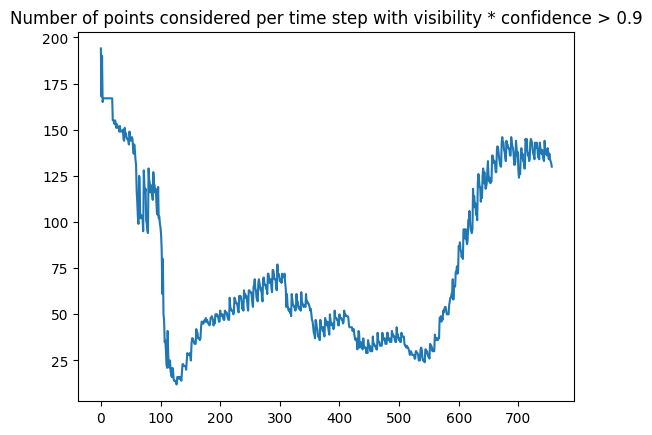

In [10]:
# How many points are being evaluated per time step?
evaluation_points.shape
plt.plot(evaluation_points.sum(axis=(0, 1)))
plt.title(
    f"Number of points considered per time step with visibility * confidence > {threshold}"
)

Text(0, 0.5, 'Value')

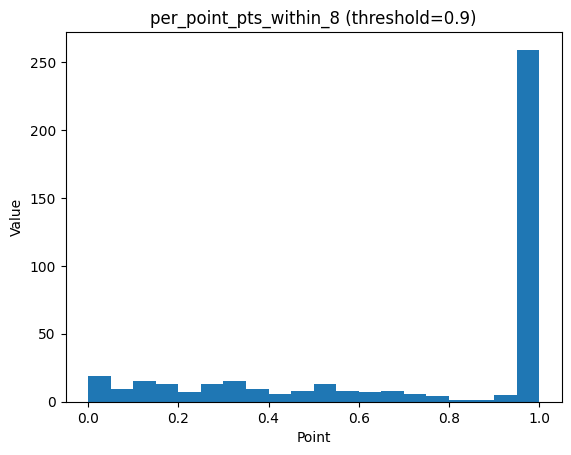

In [11]:
metric_name = "per_point_pts_within_8"
values = metrics[metric_name][0]
# If we're doing a time metric, plot a line plot
# If we're doing a per point metric, plot distribution of values
plt.plot(values) if "time" in metric_name else plt.hist(values, bins=20)
# Plot vertical line on self.interpolation_steps
plt.axvline(
    tracker_input.prepend_length, color="r", linestyle="--"
) if "time" in metric_name else None
plt.title(f"{metric_name} (threshold={threshold})")
plt.xlabel("Frame" if "time" in metric_name else "Point")
plt.ylabel("Value")

In [23]:
# ==========
# Input
# ==========
import time

import tqdm
from posingpixels.pnp import OpenCVePnP
from posingpixels.query_refiner import QueryRefiner

K = tracker_input.dataset.K
x = (
    torch.tensor(tracker_input.canonical_points, dtype=torch.float32)
    .to(device)
    .unsqueeze(0)
    .repeat(N, 1, 1)
)
gt_poses = torch.tensor(tracker_input.gt_poses[:N]).float().to(device)
gt_posed_x = apply_pose_to_points_batch(x, gt_poses[:, :3, :3], gt_poses[:, :3, 3])
y_gt = render_points_in_2d_batch(gt_posed_x, torch.tensor(K[:3, :3]).float().to(device))

y = best_coords_original.detach().clone().squeeze(0)[:N]


weights = (best_vis * best_conf).float()[:N]
weights[best_vis * best_conf < VIS_CONF_THRESHOLD] = 0
weights = weights.squeeze(0)

camKs = torch.tensor(K[np.newaxis, :], device=device).float()

# ==========
# ePnP
# ==========
# epnp_solver = RANSACePnP(num_iterations=100)
# epnp_solver = ePnP()
# epnp_R, epnp_T, _ = epnp_solver(
#     y,
#     X=x,
#     K=torch.tensor(K).to(device).float(),  # weights=weights
# )
# epnp_poses = torch.eye(4).to(device).unsqueeze(0).repeat(N, 1, 1)
# epnp_poses[:, :3, :3] = epnp_R
# epnp_poses[:, :3, 3] = epnp_T
# Start time
start_time = time.time()
epnp_cv_solver = OpenCVePnP(
    X=x[0],
    K=camKs,
    ransac_iterations=5000,
    ransac_inliner_threshold=2.0,
)
epnp_cv_R, epnp_cv_T, _ = epnp_cv_solver(
    y,
    X=x,
    K=torch.tensor(K).to(device).float(),  # weights=weights
)
epnp_cv_poses = torch.eye(4).to(device).unsqueeze(0).repeat(N, 1, 1)
epnp_cv_poses[:, :3, :3] = epnp_cv_R
epnp_cv_poses[:, :3, 3] = epnp_cv_T
# End time
end_time = time.time()
print(f"Time to run OpenCV ePnP: {end_time - start_time}")

# ==========
# Our Model Complete
# ==========
query_refiner = QueryRefiner(
    point_selector,
    epnp_cv_solver,
    torch.tensor(tracker_input.bboxes, device=device),
    torch.tensor(tracker_input.scaling, device=device),
    gt_poses[: tracker_input.prepend_length, :3, :3],
    gt_poses[: tracker_input.prepend_length, :3, 3],
    threshold=0.9,
    pad_inputs=False,
)
coordinates = pred_tracks[0, :N].clone()
visibility = pred_visibility[0, :N].clone()
confidence = pred_confidence[0, :N].clone()
optimization_results_query_refiner = []
for i in tqdm.tqdm(range(N // query_refiner.step)):
    if query_refiner.current >= N:
        break
    left = i * query_refiner.step
    right = min((i + 1) * query_refiner.step + query_refiner.step, N)
    (
        coordinates[left:right],
        visibility[left:right],
        confidence[left:right],
        opt_results,
    ) = query_refiner(
        coordinates[left:right], visibility[left:right], confidence[left:right]
    )
    optimization_results_query_refiner.append(opt_results)
query_refiner_poses = torch.eye(4).to(device).unsqueeze(0).repeat(N, 1, 1)
query_refiner_poses[:, :3, :3] = query_refiner.R
query_refiner_poses[:, :3, 3] = query_refiner.T

# ==========
# Our model
# ==========

gradient_pnp = GradientPnP(
    max_lr=0.02,
    temporal_consistency_weight=5.0,
    X=x[0],
    K=camKs,
    # R=gt_poses[0, :3, :3],
    # T=gt_poses[0, :3, 3],
)

rotations, translations, all_results = gradient_pnp(
    y,
    weights=weights,
    # R=gt_poses[0, :3, :3],
    # T=gt_poses[0, :3, 3],
    # R=torch.eye(3).to(device),
    # T=torch.zeros(3).to(device),
    R=query_refiner.R.clone(),
    T=query_refiner.T.clone(),
)

gradient_poses = torch.eye(4).to(device).unsqueeze(0).repeat(N, 1, 1)
gradient_poses[:, :3, :3] = rotations
gradient_poses[:, :3, 3] = translations


# ==========
# Visualize
# ==========

my_predicted_poses = gradient_poses
# my_predicted_poses = epnp_poses

video_permuted = full_video[0].permute(0, 2, 3, 1)
bbox_video = overlay_bounding_box_on_video(
    video_permuted[:N].detach().cpu().numpy(),
    dataset.bbox.float(),
    camKs.repeat(N, 1, 1).cpu(),
    gt_poses.detach().cpu().numpy(),
)
bbox_video = overlay_bounding_box_on_video(
    bbox_video,
    dataset.bbox.float(),
    camKs.repeat(N, 1, 1).cpu(),
    my_predicted_poses.detach().cpu().numpy(),
    color=(255, 0, 0),
)
mediapy.show_video(bbox_video[:N], fps=15)

Time to run OpenCV ePnP: 3.321218490600586


 98%|█████████▊| 3900/4000 [00:10<00:00, 382.60it/s]


In [13]:
query_refiner_poses = torch.eye(4).to(device).unsqueeze(0).repeat(N, 1, 1)
query_refiner_poses[:, :3, :3] = query_refiner.R
query_refiner_poses[:, :3, 3] = query_refiner.T

my_predicted_poses = query_refiner_poses

video_permuted = full_video[0].permute(0, 2, 3, 1)
bbox_video = overlay_bounding_box_on_video(
    video_permuted[:N].detach().cpu().numpy(),
    dataset.bbox.float(),
    camKs.repeat(N, 1, 1).cpu(),
    gt_poses.detach().cpu().numpy(),
)
bbox_video = overlay_bounding_box_on_video(
    bbox_video,
    dataset.bbox.float(),
    camKs.repeat(N, 1, 1).cpu(),
    my_predicted_poses.detach().cpu().numpy(),
    color=(255, 0, 0),
)
mediapy.show_video(bbox_video[:N], fps=15)

RANSAC CV ePnP
Percentage of ADD error less than 0.019646325799497474: 0.0
Mean ADD error: 23693699855744.016


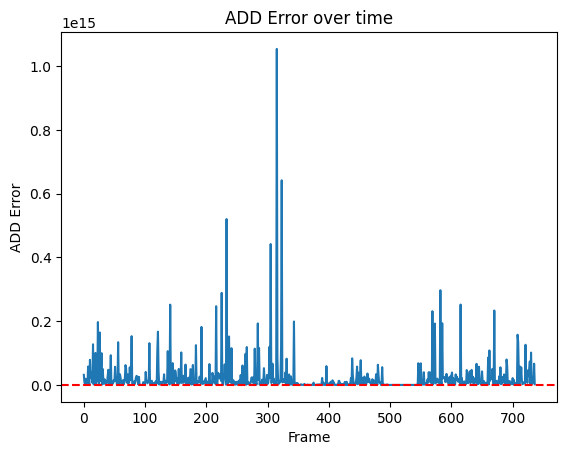

Adam Optimizer
Percentage of ADD error less than 0.019646325799497474: 0.3649932157394844
Mean ADD error: 0.024682207028948078


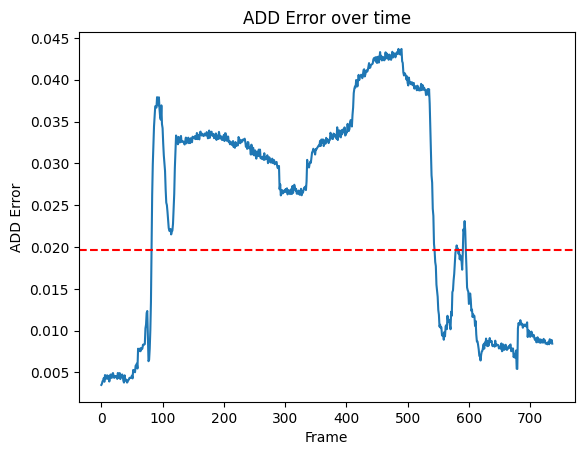

QueryRefiner Optimizer
Percentage of ADD error less than 0.019646325799497474: 0.5888738127544098
Mean ADD error: 0.02498615453285574


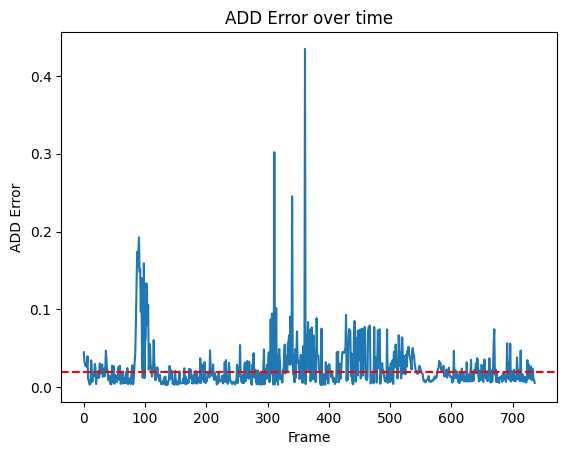

In [24]:
def compute_and_plot_add_metrics(
    model_3D_pts,
    diameter,
    predicted_poses: np.ndarray,
    gt_poses: np.ndarray,
    percentage=0.1,
):
    add_metrics = []
    for i in range(predicted_poses.shape[0]):
        add_metrics.append(
            compute_add_metrics(
                model_3D_pts,
                diameter,
                predicted_poses[i],
                gt_poses[i],
                percentage=percentage,
                return_error=True,
            )
        )
    threshold = diameter * percentage
    print(
        f"Percentage of ADD error less than {threshold}: {np.mean(np.array(add_metrics) < threshold, axis=0)}"
    )
    print(f"Mean ADD error: {np.mean(add_metrics)}")
    plt.plot(add_metrics)
    plt.axhline(threshold, color="r", linestyle="--")
    plt.title("ADD Error over time")
    plt.xlabel("Frame")
    plt.ylabel("ADD Error")
    plt.show()


# print("PyTorch ePnP")
# compute_and_plot_add_metrics(
#     np.array(dataset.get_mesh().vertices),
#     dataset.obj_diameter,
#     epnp_poses.detach().cpu().numpy()[tracker_input.prepend_length :],
#     gt_poses.detach().cpu().numpy()[tracker_input.prepend_length :],
#     percentage=0.1,
# )
print("RANSAC CV ePnP")
compute_and_plot_add_metrics(
    np.array(dataset.get_mesh().vertices),
    dataset.obj_diameter,
    epnp_cv_poses.detach().cpu().numpy()[tracker_input.prepend_length :],
    gt_poses.detach().cpu().numpy()[tracker_input.prepend_length :],
    percentage=0.1,
)
print("Adam Optimizer")
compute_and_plot_add_metrics(
    np.array(dataset.get_mesh().vertices),
    dataset.obj_diameter,
    gradient_poses.detach().cpu().numpy()[tracker_input.prepend_length :],
    gt_poses.detach().cpu().numpy()[tracker_input.prepend_length :],
    percentage=0.1,
)
print("QueryRefiner Optimizer")
compute_and_plot_add_metrics(
    np.array(dataset.get_mesh().vertices),
    dataset.obj_diameter,
    query_refiner_poses.detach().cpu().numpy()[tracker_input.prepend_length :],
    gt_poses.detach().cpu().numpy()[tracker_input.prepend_length :],
    percentage=0.1,
)

In [ ]:
# add_metrics = []
# model_3D_pts = np.array(dataset.get_mesh().vertices)
# percentage = 0.1
# threshold = dataset.obj_diameter * percentage
# print(f"Threshold: {threshold}")
# for i in range(tracker_input.prepend_length, N):
#     add_metrics.append(
#         compute_add_metrics(
#             model_3D_pts,
#             dataset.obj_diameter,
#             my_predicted_poses[i].detach().cpu().numpy(),
#             tracker.get_gt_pose(i),
#             percentage=percentage,
#             return_error=True,
#         )
#     )
# print(np.mean(np.array(add_metrics) < threshold, axis=0))
# print(np.mean(np.array(add_metrics), axis=0))

# # Divide video into chunks of 100 frames and find the max value in each chunk
# add_metrics = np.array(add_metrics)
# chunk_size = 100
# max_values = []
# max_indexes = []
# for i in range(0, len(add_metrics), chunk_size):
#     chunk = add_metrics[i : i + chunk_size]
#     max_values.append(np.max(chunk))
#     max_indexes.append(i + np.argmax(chunk))
# max_values = np.array(max_values)
# max_indexes = np.array(max_indexes)

# plt.plot(add_metrics)
# plt.title(f"ADD metrics (threshold={threshold})")
# plt.xlabel("Frame")
# plt.ylabel("Value")
# # Plot points where max values occur
# plt.scatter(max_indexes, max_values, color="r")
# # Plot horizontal line at percentage
# plt.axhline(threshold, color="r", linestyle="--")
# plt.show()
# for index in max_indexes:
#     plt.imshow(bbox_video[tracker_input.prepend_length + index])
#     plt.title(f"Frame {index}")
#     plt.show()